# INM705 - Deep Learning for Image Analysis

Authors: Laerte Adami - Alperen Erol

In [1]:
# https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py

# Custom functionalities
from Utilities.classHandler import CityscapesClass
from Utilities.datasetHandler import CityscapesDataset, visualise_and_save
from Utilities.modelHandler import modelFCN
from Utilities.metrics import metrics_per_class
from Utilities.customLoss import DiceLoss, DiceBCELoss
from Utilities.myModel import modelConstructor

import os
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.models import vgg16
from torchvision.models import ResNet50_Weights
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')
torch.cuda.empty_cache()

plt.rcParams['font.size'] = 17

/users/adcy359/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Data

In [2]:
### DATASET ###
classes = CityscapesClass("10 classes") # Pick a case: "4 classes", "6 classes", "10 classes"

img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = len(classes.labels) 
resize_dimensions = (128, 256)

dataset_args = {'image_directory' : img_directory,
                'gt_directory' : ground_truth_directory,
                'trainId' : classes.trainId,
                'colors' : classes.colors,
                'num_classes' : n_classes,
                'resize_dimensions' : resize_dimensions}

# Import datasets
dt_train = CityscapesDataset(phase = 'train', **dataset_args)

dt_val = CityscapesDataset(phase = 'val', **dataset_args)

dt_test = CityscapesDataset(phase = 'test', **dataset_args)

# Initialise dataloaders
dataloader_args = {'batch_size':32, 'shuffle':True}

## TRAIN dataset
trainloader = DataLoader(dt_train, **dataloader_args)
## VAL dataset
valloader = DataLoader(dt_val, batch_size = 32)  
## TEST dataset
testloader = DataLoader(dt_test, batch_size=10)  

print("Training set dimension: {}".format(dt_train.__len__()))

Training set dimension: 174


In [3]:
id_image = 12
# Check dataset
X_viz, X_viz_norm = dt_train.get_image_visualization(id_image)
gt_mask = dt_train.get_ground_truth(id_image)
gt_mask = gt_mask.argmax(dim=0)

bool_masks = gt_mask == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.6, colors = dt_train.colors)
to_pil_image(sm)

AttributeError: '_OpNamespace' 'image' object has no attribute 'read_file'

## Model

Models available:

- Resnet50 backbone
- Vgg16 backbone

In [6]:
## INITIALISE EXPERIMENT ##
exp_name = "TEST_NAME"

## Create results directory
results_path = os.path.join("Results/", exp_name)
checkpoint_path = os.path.join("Checkpoints/", exp_name)

if not os.path.isdir(results_path):
    os.mkdir(results_path)
    os.mkdir(checkpoint_path)
else:
    os.mkdir(results_path+"_v2")
    os.mkdir(checkpoint_path+"_v2")

### Resnet model - Simple decoder

In [4]:
##MODEL Pretrained with RESNET 50
#Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT

#Initialise backbone weights
model = fcn_resnet50(backbone_weights=backbone_weights).to(device)
#model = fcn_resnet50().to(device)

model.backbone.requires_grad_(True)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True);

### Resnet model - Improved decoder

Source for the improved architecture: https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py

In [ ]:
fcn_backbone = fcn_resnet50()

improved_decoder = nn.Sequential(nn.ReLU(),
                                 nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.Conv2d(256, 128, kernel_size=1),
                                 nn.BatchNorm2d(128),
                                 nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.Conv2d(64, n_classes, kernel_size=1))

model = modelConstructor(fcn_backbone.backbone, improved_decoder)

### Resnet model - Modified backbone and improved decoder 

In [8]:
fcn_backbone = fcn_resnet50().backbone

# Remove last layer in the Resnet backbone
fcn_backbone_mod = nn.Sequential(*[fcn_backbone.conv1,
                                   fcn_backbone.bn1, 
                                   fcn_backbone.relu, 
                                   fcn_backbone.maxpool, 
                                   fcn_backbone.layer1, 
                                   fcn_backbone.layer2, 
                                   fcn_backbone.layer3])

improved_decoder = nn.Sequential(nn.ReLU(),
                                 nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.Conv2d(256, 128, kernel_size=1),
                                 nn.BatchNorm2d(128),
                                 nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.Conv2d(64, n_classes, kernel_size=1))

model = modelConstructor(fcn_backbone_mod, improved_decoder)

### VGG model - Simple decoder

In [9]:
#Define backbone
vgg = vgg16() 
vgg_backbone = vgg.features

#Define decoder
fcn = fcn_resnet50()

#Adapt FCN simple decoder 
fcn_classifier = fcn.classifier
fcn_classifier[0] = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
fcn_classifier[1] = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
fcn_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

model = modelConstructor(vgg_backbone, fcn_classifier, resize_dimensions)

### VGG model - Improved decoder

In [3]:
#Define backbone
vgg = vgg16() 
vgg_backbone = vgg.features

#Define decoder
improved_decoder = nn.Sequential(nn.ReLU(),
                                 nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(128),
                                 nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(32),
                                 nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(16),
                                 nn.Conv2d(16, n_classes, kernel_size=1))

model = modelConstructor(vgg_backbone, improved_decoder)

NameError: name 'vgg16' is not defined

### VGG model - Modified backbone and improved decoder

In [12]:
#Define backbone
vgg = vgg16() 
vgg_backbone = vgg.features
#Remove final two layers in the vgg backbone
layers = [vgg_backbone[idx] for idx in range(29)]
vgg_backbone_mod = nn.Sequential(*layers)

#Define decoder
improved_decoder = nn.Sequential(nn.ReLU(),
                                 nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(256),
                                 nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(128),
                                 nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
                                 nn.BatchNorm2d(32),
                                 nn.Conv2d(32, n_classes, kernel_size=1))

model = modelConstructor(vgg_backbone_mod, improved_decoder)

## Training

In [7]:
## Models paramaters
total_epochs      = 30
save_every_epochs = 6 
learning_rate     = 1e-4
w_decay           = 1e-3

# Loss functions
cel = CrossEntropyLoss()
diceloss = DiceLoss()
bce_diceloss = DiceBCELoss()

# Adam optimizer
ad = Adam(model.parameters(), lr = learning_rate, weight_decay = w_decay)

# Initialise the model handler
my_model = modelFCN(model, loss_function = bce_diceloss, optimizer = ad )
my_model.model.to(device);

In [8]:
## TRAINING PHASE ##
start_time = time.time()

L, ckp_list  = my_model.train_model(trainloader, total_epochs=total_epochs, save_every_epochs = save_every_epochs, ckp_name = checkpoint_path+"/"+exp_name)

comp_time = time.time() - start_time
print("Computational time required: {} h".format(round(comp_time / 3600,0)))

fig, ax = plt.subplots()
ax.plot(L, linewidth = 3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");
plt.savefig(results_path+"/training_loss.png")

AttributeError: '_OpNamespace' 'image' object has no attribute 'read_file'

## Model evaluation and visualisation

In [14]:
ckp_list

['Checkpoints/TESTONE/TESTONE_1.pth']

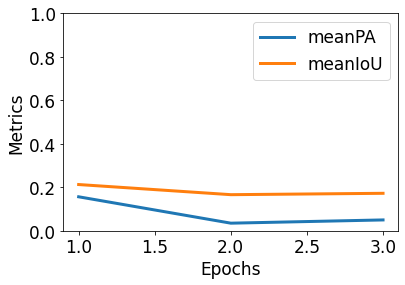

In [15]:
image_id = 20
image_id2 = 9 

# Create variables to store progressive results
grid_list = []
e_list    = []
acc_list  = []
iou_list  = []

for ckp in ckp_list:
    
    # Extract the epoch number
    e = int(ckp.split('_')[-1].split('.pth')[0])
    e_list.append(e)
    
    # Metrics computation
    mPA, PAk, mIoU, IoUk = my_model.evaluate_model(next(iter(valloader)), ckp)
    acc_list.append(mPA)
    iou_list.append(mIoU)
    
    # Results visualisation
    grid = visualise_and_save(ckp, my_model, dt_val, image_id = image_id, save_name = results_path + "/id{}_ep{}.png".format(image_id,e))
    grid2 = visualise_and_save(ckp, my_model, dt_val, image_id = image_id2, save_name = results_path + "/id{}_ep{}.png".format(image_id2,e))
    grid_list.append(grid)

# Plot accuracy and meanIoU over epochs
fig, ax = plt.subplots()
ax.plot(e_list, acc_list , linewidth = 3, label = 'meanPA')
ax.plot(e_list, iou_list , linewidth = 3, label = 'meanIoU')
ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_ylim(0,1)
plt.legend()
plt.savefig(results_path+"/mPA_epochs.png")

In [ ]:
print("mPA: {}, mIoU: {}".format(mPA, mIoU))

In [ ]:
metrics_per_class(classes.labels, PAk, IoUk, results_path)

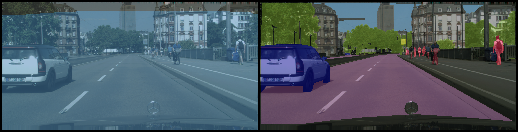

In [16]:
to_pil_image(grid_list[-1])

## Check the model

In [10]:
model = vgg_backbone

In [11]:
from Utilities.torchsummaryNew import summary

model.to(device);

summary(model, (3, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,792
              ReLU-2         [-1, 64, 128, 256]               0
            Conv2d-3         [-1, 64, 128, 256]          36,928
              ReLU-4         [-1, 64, 128, 256]               0
         MaxPool2d-5          [-1, 64, 64, 128]               0
            Conv2d-6         [-1, 128, 64, 128]          73,856
              ReLU-7         [-1, 128, 64, 128]               0
            Conv2d-8         [-1, 128, 64, 128]         147,584
              ReLU-9         [-1, 128, 64, 128]               0
        MaxPool2d-10          [-1, 128, 32, 64]               0
           Conv2d-11          [-1, 256, 32, 64]         295,168
             ReLU-12          [-1, 256, 32, 64]               0
           Conv2d-13          [-1, 256, 32, 64]         590,080
             ReLU-14          [-1, 256,

(tensor(14714688), tensor(14714688))

In [15]:
model = vgg_backbone_mod

In [16]:
from Utilities.torchsummaryNew import summary

model.to(device);

summary(model, (3, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,792
              ReLU-2         [-1, 64, 128, 256]               0
            Conv2d-3         [-1, 64, 128, 256]          36,928
              ReLU-4         [-1, 64, 128, 256]               0
         MaxPool2d-5          [-1, 64, 64, 128]               0
            Conv2d-6         [-1, 128, 64, 128]          73,856
              ReLU-7         [-1, 128, 64, 128]               0
            Conv2d-8         [-1, 128, 64, 128]         147,584
              ReLU-9         [-1, 128, 64, 128]               0
        MaxPool2d-10          [-1, 128, 32, 64]               0
           Conv2d-11          [-1, 256, 32, 64]         295,168
             ReLU-12          [-1, 256, 32, 64]               0
           Conv2d-13          [-1, 256, 32, 64]         590,080
             ReLU-14          [-1, 256,

(tensor(14714688), tensor(14714688))